Desarrollo con DeepLabV3 reajustado para detectar mastocitos y K-means para generar los datos de entrenamiento

In [5]:
import os
import cv2
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

# Rutas de entrada y salida
mosaico_dir = "mosaicos"  # Carpeta con mosaicos generados
output_dir = "mascaras"  # Carpeta para guardar las segmentaciones
os.makedirs(output_dir, exist_ok=True)

# Parámetros de K-Means
k = 2  # Número de clases (mastocitos y no mastocitos)
resize_dim = (512, 512)  # Redimensionar mosaico para procesar más rápido (opcional)

# Función para aplicar K-Means a un mosaico
def segmentar_kmeans_2clases(image_path, k=2, resize_dim=None):
    # Cargar la imagen
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"No se pudo cargar la imagen: {image_path}")
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Redimensionar si se especifica
    original_size = image.shape[:2]
    if resize_dim:
        image = cv2.resize(image, resize_dim)
    
    # Reestructurar la imagen para K-Means
    pixels = image.reshape((-1, 3))
    pixels = np.float32(pixels)

    # Aplicar K-Means
    _, labels, centers = cv2.kmeans(pixels, k, None,
                                    criteria=(cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2),
                                    attempts=10, flags=cv2.KMEANS_RANDOM_CENTERS)
    segmented_image = labels.flatten().reshape(image.shape[:2])

    # Restaurar el tamaño original si se redimensionó
    if resize_dim:
        segmented_image = cv2.resize(segmented_image, (original_size[1], original_size[0]), interpolation=cv2.INTER_NEAREST)
    
    # Normalizar las clases: 0 para "no mastocitos", 1 para "mastocitos"
    # Suponemos que el cluster con menor intensidad promedio es "mastocitos"
    class_order = np.argsort(np.sum(centers, axis=1))  # Ordenar clusters por brillo
    segmented_image = np.where(segmented_image == class_order[0], 1, 0)  # Mastocitos = 1, No mastocitos = 0
    
    return segmented_image

# Procesar todos los mosaicos
for mosaic_file in os.listdir(mosaico_dir):
    mosaic_path = os.path.join(mosaico_dir, mosaic_file)
    print(f"Procesando mosaico: {mosaic_file}")
    
    try:
        # Segmentar el mosaico
        segmented = segmentar_kmeans_2clases(mosaic_path, k=k, resize_dim=resize_dim)
        
        # Guardar la segmentación como máscara binaria
        output_path = os.path.join(output_dir, f"segmented_{mosaic_file}")
        Image.fromarray((segmented * 255).astype(np.uint8)).save(output_path)  # Convertir a escala de grises

        print(f"Segmentación guardada: {output_path}")
    except Exception as e:
        print(f"Error procesando {mosaic_file}: {e}")

print("Segmentación completada para todos los mosaicos.")

Procesando mosaico: tile_11100_12041.png
Segmentación guardada: mascaras\segmented_tile_11100_12041.png
Procesando mosaico: tile_11100_16041.png
Segmentación guardada: mascaras\segmented_tile_11100_16041.png
Procesando mosaico: tile_11100_20041.png
Segmentación guardada: mascaras\segmented_tile_11100_20041.png
Procesando mosaico: tile_11100_24041.png
Segmentación guardada: mascaras\segmented_tile_11100_24041.png
Procesando mosaico: tile_11100_28041.png
Segmentación guardada: mascaras\segmented_tile_11100_28041.png
Procesando mosaico: tile_11100_4041.png
Segmentación guardada: mascaras\segmented_tile_11100_4041.png
Procesando mosaico: tile_11100_41.png
Segmentación guardada: mascaras\segmented_tile_11100_41.png
Procesando mosaico: tile_11100_8041.png
Segmentación guardada: mascaras\segmented_tile_11100_8041.png
Procesando mosaico: tile_15100_12041.png
Segmentación guardada: mascaras\segmented_tile_15100_12041.png
Procesando mosaico: tile_15100_16041.png
Segmentación guardada: mascaras\s

In [6]:
import os
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image

# Dataset personalizado
class MastocitosDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform_image=None, transform_mask=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform_image = transform_image
        self.transform_mask = transform_mask
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Ruta a la imagen y la máscara correspondiente
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx].replace("tile_", "segmented_tile_"))
        
        # Cargar imagen y máscara
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # Máscara en escala de grises
        
        # Aplicar transformaciones
        if self.transform_image:
            image = self.transform_image(image)
        if self.transform_mask:
            mask = self.transform_mask(mask)
        
        return image, mask

# Transformaciones separadas para imágenes y máscaras
transform_image = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_mask = transforms.Compose([
    transforms.ToTensor()  # Convierte la máscara a un tensor (1 canal)
])

# Rutas a imágenes y máscaras
image_dir = "mosaicos"  # Carpeta con mosaicos
mask_dir = "mascaras"  # Carpeta con máscaras generadas

# Crear dataset y dividir en entrenamiento y validación
dataset = MastocitosDataset(image_dir, mask_dir, transform_image=transform_image, transform_mask=transform_mask)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Crear dataloaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

# Verificar las dimensiones del dataset
for images, masks in train_loader:
    print(f"Shape de las imágenes: {images.shape}")  # [batch_size, 3, H, W]
    print(f"Shape de las máscaras: {masks.shape}")  # [batch_size, 1, H, W]
    break


Shape de las imágenes: torch.Size([4, 3, 4000, 4000])
Shape de las máscaras: torch.Size([4, 1, 4000, 4000])


Shape de las imágenes: torch.Size([2, 3, 512, 512])
Shape de las máscaras: torch.Size([2, 1, 512, 512])
Epoch 1/10, Loss: 0.6035
Epoch 2/10, Loss: 0.5358
Epoch 3/10, Loss: 0.5127
Epoch 4/10, Loss: 0.4949
Epoch 5/10, Loss: 0.4921
Epoch 6/10, Loss: 0.4800
Epoch 7/10, Loss: 0.4708
Epoch 8/10, Loss: 0.4604
Epoch 9/10, Loss: 0.4670
Epoch 10/10, Loss: 0.4645
Modelo entrenado guardado como mastocitos_detector.pth
Validation Loss: 0.5112


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.265406..2.465708].


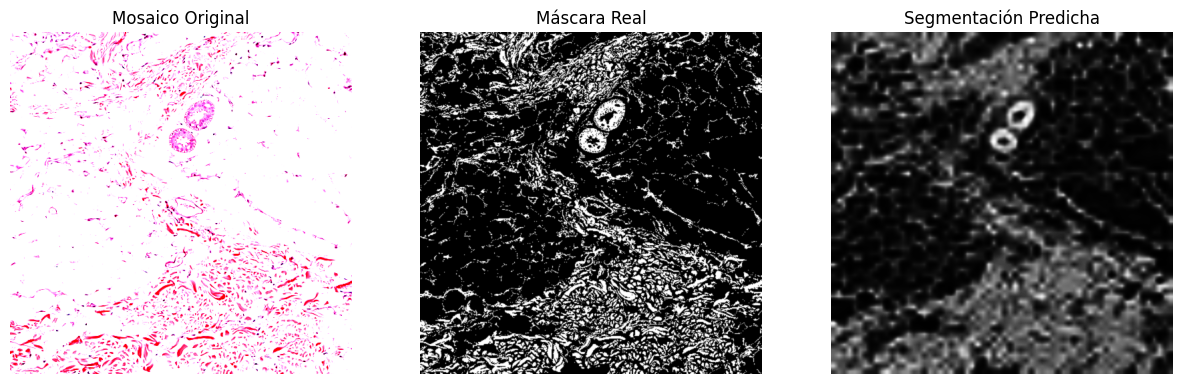

In [7]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import matplotlib.pyplot as plt

# Parámetros globales
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 10
batch_size = 2
learning_rate = 1e-4
resize_dim = (512, 512)  # Redimensionar imágenes y máscaras a 512x512

# Dataset personalizado
class MastocitosDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform_image=None, transform_mask=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform_image = transform_image
        self.transform_mask = transform_mask
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Ruta a la imagen y la máscara correspondiente
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx].replace("tile_", "segmented_tile_"))
        
        # Cargar imagen y máscara
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # Máscara en escala de grises
        
        # Aplicar transformaciones
        if self.transform_image:
            image = self.transform_image(image)
        if self.transform_mask:
            mask = self.transform_mask(mask)
        
        return image, mask

# Transformaciones para imágenes y máscaras
transform_image = transforms.Compose([
    transforms.Resize(resize_dim),  # Redimensionar imágenes
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_mask = transforms.Compose([
    transforms.Resize(resize_dim),  # Redimensionar máscaras
    transforms.ToTensor()
])

# Rutas a imágenes y máscaras
image_dir = "mosaicos"  # Carpeta con mosaicos
mask_dir = "mascaras"  # Carpeta con máscaras generadas

# Crear dataset y dividir en entrenamiento y validación
dataset = MastocitosDataset(image_dir, mask_dir, transform_image=transform_image, transform_mask=transform_mask)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Crear dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Verificar las dimensiones de un batch
for images, masks in train_loader:
    print(f"Shape de las imágenes: {images.shape}")  # [batch_size, 3, H, W]
    print(f"Shape de las máscaras: {masks.shape}")  # [batch_size, 1, H, W]
    break

# Modelo DeepLabV3
model = models.segmentation.deeplabv3_resnet50(pretrained=True)
model.classifier[4] = nn.Conv2d(256, 1, kernel_size=1)  # Ajustar a 1 clase (mastocitos)
model = model.to(device)

# Configurar pérdida y optimizador
criterion = nn.BCEWithLogitsLoss()  # Pérdida para máscaras binarias
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Entrenamiento del modelo
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        # No agregar dimensiones adicionales
        outputs = model(images)['out']
        loss = criterion(outputs, masks)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss / len(train_loader):.4f}")

# Guardar el modelo entrenado
torch.save(model.state_dict(), "mastocitos_detector.pth")
print("Modelo entrenado guardado como mastocitos_detector.pth")

# Validación del modelo
model.eval()
val_loss = 0.0
with torch.no_grad():
    for images, masks in val_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)['out']
        loss = criterion(outputs, masks)
        val_loss += loss.item()

print(f"Validation Loss: {val_loss / len(val_loader):.4f}")

def visualizar_prediccion(image, mask, prediction):
    plt.figure(figsize=(15, 5))
    
    # Mostrar mosaico original
    plt.subplot(1, 3, 1)
    plt.title("Mosaico Original")
    plt.imshow(image.permute(1, 2, 0).cpu().numpy())  # Convertir a numpy para mostrar
    plt.axis("off")

    # Mostrar máscara real
    plt.subplot(1, 3, 2)
    plt.title("Máscara Real")
    plt.imshow(mask.squeeze(0).cpu().numpy(), cmap="gray")  # Reducir dimensiones
    plt.axis("off")

    # Mostrar predicción
    plt.subplot(1, 3, 3)
    plt.title("Segmentación Predicha")
    plt.imshow(torch.sigmoid(prediction).squeeze(0).squeeze(0).cpu().numpy(), cmap="gray")  # Asegurar que sea 2D
    plt.axis("off")
    
    plt.show()


# Probar en un mosaico de validación
image, mask = next(iter(val_loader))
image, mask = image[0].to(device), mask[0].to(device)
with torch.no_grad():
    prediction = model(image.unsqueeze(0))['out']
visualizar_prediccion(image, mask, prediction)
